# 04 — RFM Feature Engineering

- E-commerce Customer Segmentation & Prediction

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import warnings

from sklearn.model_selection import train_test_split

In [2]:
warnings.filterwarnings("ignore")

In [3]:
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["figure.dpi"] = 100

In [4]:
df = pd.read_csv(
    "../data/cleaned_data.csv",
    dtype={"CustomerID": str}
)

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"], format="mixed")

print(f"Shape: {df.shape}")
df.head()

Shape: (524878, 9)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [5]:
# REMOVING MISSING CUSTOMER ID

before = len(df)
df = df.dropna(subset=["CustomerID"])
after = len(df)

print(f"Rows Removed  : {before - after:,}")
print(f"Remaining Rows: {after:,}")
print(f"Total Customers: {df['CustomerID'].nunique():,}")

Rows Removed  : 132,186
Remaining Rows: 392,692
Total Customers: 4,338


In [6]:
# Calculating the Snapshot Date (One Day after the last transaction)

snapshot_date = df["InvoiceDate"].max() + pd.Timedelta(days=1)

print(f"Last Transaction : {df['InvoiceDate'].max()}")
print(f"Snapshot Date    : {snapshot_date}")

Last Transaction : 2011-12-09 12:50:00
Snapshot Date    : 2011-12-10 12:50:00


In [7]:
# RFM

rfm = df.groupby("CustomerID").agg(
    Recency   = ("InvoiceDate", lambda x: (snapshot_date - x.max()).days),
    Frequency = ("InvoiceNo", "nunique"),
    Monetary  = ("TotalPrice", "sum")
).reset_index()

print(f"RFM Table Shape: {rfm.shape}")
rfm.head(10)

RFM Table Shape: (4338, 4)


,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.60
1,12347,2,7,4310.00
2,12348,75,4,1797.24
3,12349,19,1,1757.55
4,12350,310,1,334.40
5,12352,36,8,2506.04
6,12353,204,1,89.00
7,12354,232,1,1079.40
8,12355,214,1,459.40
9,12356,23,3,2811.43


In [8]:
# RFM Statistics

rfm[["Recency", "Frequency", "Monetary"]].describe().round(2)

,Recency,Frequency,Monetary
count,4338.00,4338.00,4338.00
mean,92.54,4.27,2048.69
std,100.01,7.70,8985.23
min,1.00,1.00,3.75
25%,18.00,1.00,306.48
50%,51.00,2.00,668.57
75%,142.00,5.00,1660.60
max,374.00,209.00,280206.02


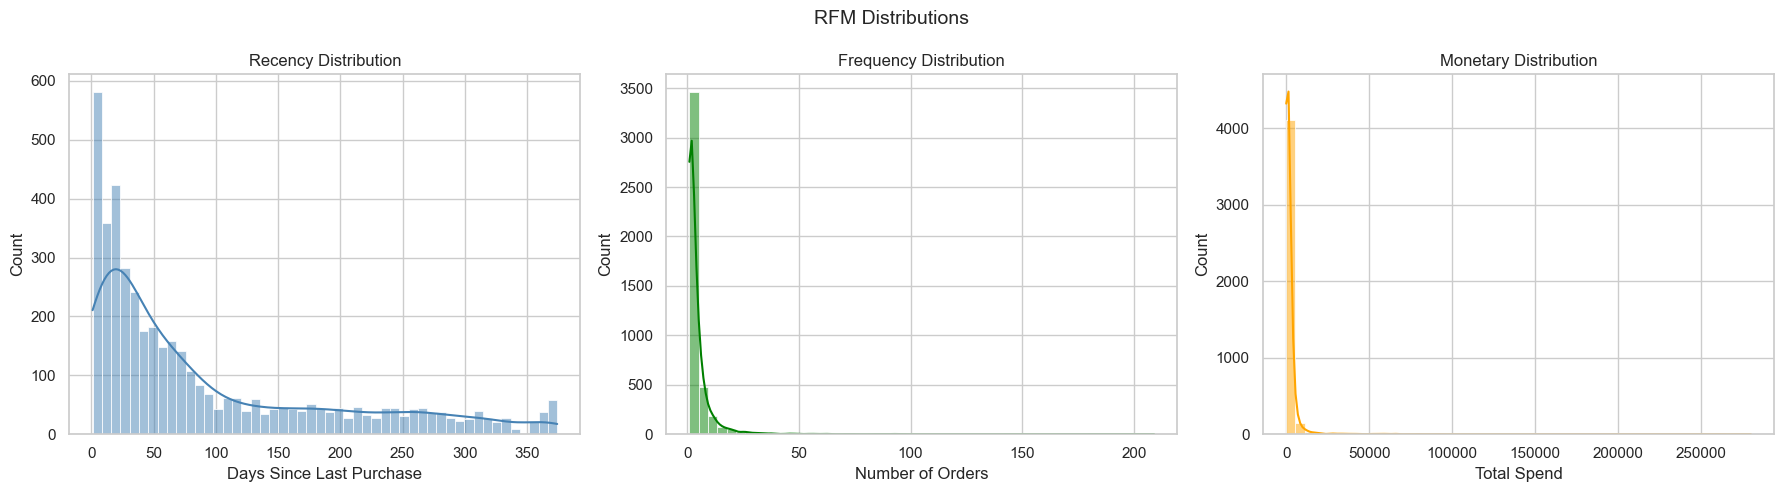

In [9]:
# RFM Distribution

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(rfm["Recency"], bins=50, kde=True, color="steelblue", ax=axes[0])
axes[0].set_title("Recency Distribution")
axes[0].set_xlabel("Days Since Last Purchase")

sns.histplot(rfm["Frequency"], bins=50, kde=True, color="green", ax=axes[1])
axes[1].set_title("Frequency Distribution")
axes[1].set_xlabel("Number of Orders")

sns.histplot(rfm["Monetary"], bins=50, kde=True, color="orange", ax=axes[2])
axes[2].set_title("Monetary Distribution")
axes[2].set_xlabel("Total Spend")

plt.suptitle("RFM Distributions", fontsize=14)
plt.tight_layout()
plt.show()

In [10]:
# Log Transformation ( As all three are Right Skewed)

rfm["Recency_log"]   = np.log1p(rfm["Recency"])
rfm["Frequency_log"] = np.log1p(rfm["Frequency"])
rfm["Monetary_log"]  = np.log1p(rfm["Monetary"])

In [11]:
X = rfm[["Recency_log", "Frequency_log", "Monetary_log"]]

X_train, X_test = train_test_split(
    X,
    test_size=0.2,
    random_state=42
)

print(f"Train Set : {X_train.shape}")
print(f"Test Set  : {X_test.shape}")
print("Split done BEFORE scaling — no data leakage")

Train Set : (3470, 3)
Test Set  : (868, 3)
Split done BEFORE scaling — no data leakage


In [12]:
# Fit ONLY on training data


scaler = StandardScaler()
scaler.fit(X_train)

# Transform both using train statistics
X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Convert to DataFrames
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]
)
X_test_scaled = pd.DataFrame(
    X_test_scaled,
    columns=["Recency_scaled", "Frequency_scaled", "Monetary_scaled"]
)

print("Scaler fitted on TRAINING data only")
print(f"Train Scaled Shape : {X_train_scaled.shape}")
print(f"Test Scaled Shape  : {X_test_scaled.shape}")

Scaler fitted on TRAINING data only
Train Scaled Shape : (3470, 3)
Test Scaled Shape  : (868, 3)


In [13]:
# Save full RFM (unscaled) for reference
rfm.to_csv("../data/rfm_data.csv", index=False)

# Save train and test scaled separately
X_train_scaled_save = X_train_scaled.copy()
X_train_scaled_save.index = X_train.index
X_train_scaled_save.to_csv("../data/rfm_train_scaled.csv", index=True)

X_test_scaled_save = X_test_scaled.copy()
X_test_scaled_save.index = X_test.index
X_test_scaled_save.to_csv("../data/rfm_test_scaled.csv", index=True)

print("RFM data saved")
print("Train scaled saved")
print("Test scaled saved")

RFM data saved
Train scaled saved
Test scaled saved


In [14]:
# RFM Summary 



print("RFM ENGINEERING SUMMARY\n")

print(f"Total Customers        : {rfm.shape[0]:,}")
print(f"Training Customers     : {X_train.shape[0]:,}")
print(f"Testing Customers      : {X_test.shape[0]:,}")
print(f"Average Recency        : {rfm['Recency'].mean().round(2)} days")
print(f"Average Frequency      : {rfm['Frequency'].mean().round(2)} orders")
print(f"Average Monetary       : {rfm['Monetary'].mean().round(2)}")
print(f"Most Recent Customer   : {rfm['Recency'].min()} days ago")
print(f"Most Frequent Customer : {rfm['Frequency'].max()} orders")
print(f"Highest Spender        : {rfm['Monetary'].max().round(2)}")

print("\n\nRFM complete — proceed to 05_segmentation.ipynb")

RFM ENGINEERING SUMMARY

Total Customers        : 4,338
Training Customers     : 3,470
Testing Customers      : 868
Average Recency        : 92.54 days
Average Frequency      : 4.27 orders
Average Monetary       : 2048.69
Most Recent Customer   : 1 days ago
Most Frequent Customer : 209 orders
Highest Spender        : 280206.02


RFM complete — proceed to 05_segmentation.ipynb
